In [1]:
import numpy as np
from itertools import product
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

**generate_hooks**     
* Generates the position of hooks, given a particular number of hooks, wheel pixel size, and hook pixel size.
* Creates 2 lists of positions (one for the anticlockwise side, one for the clockwise), and weaves them together so that the order they appear in the final output is the order of nodes anticlockwise around the frame.

**through_pixels**
* Given 2 hooks, generates a list of pixels that the line connecting them runs through.

**build_through_pixels_dict**
* Uses `through_pixels` to build up a dictionary of all possible lines connecting 2 hooks.
* Can be run at the start of a project, and doesn't need to be run again.
* Prints out an ongoing estimate of how much time is left.

In [2]:
def generate_hooks(n_hooks, wheel_pixel_size, hook_pixel_size):
    
    r = (wheel_pixel_size / 2) - 1
    
    theta = np.arange(n_hooks, dtype="float64") / n_hooks * (2 * np.pi)
    
    epsilon = np.arcsin(hook_pixel_size / wheel_pixel_size)
    
    theta_acw = theta.copy() + epsilon
    theta_cw = theta.copy() - epsilon
    
    theta = np.stack((theta_cw, theta_acw)).ravel("F")
    
    x = r * (1 + np.cos(theta)) + 0.5
    y = r * (1 + np.sin(theta)) + 0.5
    
    return np.array((x,y)).T


def through_pixels(p0, p1):
    
    d = max(int(((p0[0]-p1[0])**2 + (p0[1]-p1[1])**2) ** 0.5), 1)
    
    pixels = p0 + (p1-p0) * np.array([np.arange(d+1), np.arange(d+1)]).T / d
    pixels = np.unique(np.round(pixels), axis=0).astype(int)
    
    return pixels


def build_through_pixels_dict(n_hooks, wheel_pixel_size, hook_pixel_size):

    n_hook_sides = n_hooks * 2

    l = [(0,1)]
    for j in range(n_hook_sides):
        for i in range(j):
            if j-i > 10 and j-i < (n_hook_sides - 10):
                l.append((i, j))
    
    random_order = np.random.choice(len(l),len(l),replace=False)
    
    d = {}    
    t_list = []
    t0 = time.time()
    
    for n in range(len(l)):
        (i, j) = l[random_order[n]]
        p0, p1 = hooks[i], hooks[j]
        d[(i,j)] = through_pixels(p0, p1)
        
        t = time.time() - t0
        t_left = t * (len(l) - n - 1) / (n + 1)
        print(f"time left = {time.strftime('%M:%S', time.gmtime(t_left))}", end="\r")
    
    clear_output()
    return d

**fitness**
* Measures how much a line improves the image. 
* Improvement is difference in penalty between the old and new images (i.e. a large decrease in penalty means a large fitness value).
* Penalty depends on the lightness_penalty, w, w_pos, w_neg and line_norm_mode parameters, however it is always some kind of weighted average of the absolute values of the pixels in the image. 

**optimise_fitness**
* Process of adding a new line is as follows:
    1. Generates all possible lines starting from this hook (or a subset of lines, if you are using the `time_saver` parameter). 
    2. Finds the line with the best fitness score.
    2. Subtracts this line from the image.
    3. Returns the new image, and the best line.

In [3]:
def fitness(image, line, darkness, lp, w, w_pos, w_neg, line_norm_mode):
    
    pixels = through_pixels_dict[tuple(sorted(line))]
    
    old_pixel_values = image[tuple(pixels.T)]
    new_pixel_values = old_pixel_values - darkness

    if type(w) == bool and type(w_pos) == bool:
        new_penalty = new_pixel_values.sum() - (1 + lp) * new_pixel_values[new_pixel_values < 0].sum()
        old_penalty = old_pixel_values.sum() - (1 + lp) * old_pixel_values[old_pixel_values < 0].sum()
    elif type(w_pos) == bool:
        pixel_weightings = w[tuple(pixels.T)]
        new_w_pixel_values = new_pixel_values * pixel_weightings
        old_w_pixel_values = old_pixel_values * pixel_weightings
        new_penalty = new_w_pixel_values.sum() - (1 + lp) * new_w_pixel_values[new_pixel_values < 0].sum()
        old_penalty = old_w_pixel_values.sum() - (1 + lp) * old_w_pixel_values[old_pixel_values < 0].sum()
    elif type(w) == bool:
        pos_pixel_weightings = w_pos[tuple(pixels.T)]
        neg_pixel_weightings = w_neg[tuple(pixels.T)]
        new_wpos_pixel_values = new_pixel_values * pos_pixel_weightings
        new_wneg_pixel_values = new_pixel_values * neg_pixel_weightings
        old_wpos_pixel_values = old_pixel_values * pos_pixel_weightings
        old_wneg_pixel_values = old_pixel_values * neg_pixel_weightings
        new_penalty = new_wpos_pixel_values[new_pixel_values > 0].sum() - lp * new_wneg_pixel_values[new_pixel_values < 0].sum()
        old_penalty = old_wpos_pixel_values[old_pixel_values > 0].sum() - lp * old_wneg_pixel_values[old_pixel_values < 0].sum()

    if line_norm_mode == "length":
        line_norm = len(pixels)
    elif line_norm_mode == "weighted length":
        if type(w_pos) == bool:
            line_norm = pixel_weightings.sum()
        else:
            line_norm = pos_pixel_weightings.sum()
    elif line_norm_mode == "none":
        line_norm = 1
        
    if line_norm == 0:
        return 0
    else:
        return (old_penalty - new_penalty) / line_norm


def optimise_fitness(image, previous_edge, darkness, lightness_penalty, list_of_lines, 
                     w, w_pos, w_neg, line_norm_mode, time_saver):
    
    if previous_edge % 2 == 0:
        starting_edge = previous_edge + 1
    else:
        starting_edge = previous_edge - 1
          
    sides_A = np.ones(n_hooks * 2) * starting_edge
    sides_B = np.arange(n_hooks * 2)
    next_lines = np.stack((sides_A, sides_B)).ravel("F").reshape((n_hooks * 2, 2)).astype(int)
    mask = (np.abs(next_lines.T[1] - next_lines.T[0]) > 10) & (np.abs(next_lines.T[1] - next_lines.T[0]) < n_hooks * 2 - 10)
    next_lines = next_lines[mask]
    
    if time_saver == 1:
        next_lines = next_lines.tolist()
    else:
        next_lines = next_lines[np.random.choice(np.arange(len(next_lines)), int(len(next_lines) * time_saver))].tolist()

    fitness_list = [fitness(image, line, darkness, lightness_penalty, w, w_pos, w_neg, line_norm_mode) for line in next_lines]
    best_line_idx = fitness_list.index(max(fitness_list))
    best_line = next_lines[best_line_idx]

    pixels = through_pixels_dict[tuple(sorted(best_line))]
    image[tuple(pixels.T)] -= darkness
    
    return image, best_line

**find_lines**
* Calls `optimise_fitness` multiple times to draw a set of lines.
* Updates the image and the list of lines with each line drawn.
* Every 100 lines drawn, prints output that describes the progress of the algorithm (including average penalty, current runtime, and projected total runtime).

**get_penalty**
* Calculates the total penalty of the image.
* This is different depending on whether importance weightings are being used.

In [4]:
def find_lines(image, n_lines, darkness, lightness_penalty, line_norm_mode, w=False, w_pos=False, w_neg=False, time_saver=1):
    
    list_of_lines = []
    previous_edge = np.random.choice(n_hooks * 2)
    
    image_copy = image.copy()
    
    for i in range(n_lines):
        
        if i == 0:
            t0 = time.time()
            initial_penalty = get_penalty(image_copy, lightness_penalty, w, w_pos, w_neg)
            initial_avg_penalty = f'{initial_penalty / (wheel_pixel_size ** 2):.2f}'
        elif i%100 == 0:
            t_so_far = time.strftime('%M:%S', time.gmtime(time.time() - t0))
            t_left = time.strftime('%M:%S', time.gmtime((time.time() - t0) * (n_lines - i) / i))   
            penalty = get_penalty(image, lightness_penalty, w, w_pos, w_neg)
            avg_penalty = f'{penalty / (wheel_pixel_size ** 2):.2f}'
            print(f"{i}/{n_lines}, average penalty = {avg_penalty}/{initial_avg_penalty}, \
time = {t_so_far}, time left = {t_left}    ", end="\r")                
        
        image, line = optimise_fitness(image_copy, previous_edge, darkness, lightness_penalty, list_of_lines, 
                                       w, w_pos, w_neg, line_norm_mode, time_saver)
        previous_edge = line[1]
        
        list_of_lines.append(line)

    
    clear_output()
    
    penalty = get_penalty(image_copy, lightness_penalty, w, w_pos, w_neg)
    avg_penalty = f'{penalty / (wheel_pixel_size ** 2):.2f}'
    print(f"{len(list_of_lines)}/{n_lines}, average penalty = {avg_penalty}/{initial_avg_penalty}")
    print("time = " + time.strftime('%M:%S', time.gmtime(time.time() - t0)))
    
    return list_of_lines
        

def get_penalty(image, lightness_penalty, w, w_pos, w_neg):
    
    if type(w) == bool and type(w_pos) == bool:
        return image.sum() - (1 + lightness_penalty) * image[image<0].sum()
    elif type(w_pos) == bool:
        image_w = image * w
        return image_w.sum() - (1 + lightness_penalty) * image_w[image<0].sum()
    elif type(w) == bool:
        image_wpos = image * w_pos
        image_wneg = image * w_neg
        return image_wpos[image>0].sum() - lightness_penalty * image_wneg[image<0].sum() 

**prepare_image**
* Takes a jpeg or png image file, and converts it into a square array of bytes.
* `colour` (boolean) determines whether image is meant to have its colour read rather than darkness. If True then the pixel values will represent the saturation of the image, if False then they will represent the darkness.
* `weighting` (boolean) determines whether image is meant to be an importance weighting. If True, the array has values between 0 and 1, where black = 1 = maximum importance, and white = 0 = no importance).

**display_images**
* Displays images (i.e. output from `prepare_image`) inline, in a nice format.

In [5]:
def prepare_image(file_name, colour=False, weighting=False):
    
    image = Image.open(file_name).resize((wheel_pixel_size, wheel_pixel_size))
    
    if colour:
        image = np.array(image.convert(mode="HSV").getdata()).reshape((wheel_pixel_size, wheel_pixel_size,3))[:,:,1]
    elif weighting:     
        image = 1 - np.array(image.convert(mode="L").getdata()).reshape((wheel_pixel_size, wheel_pixel_size)) / 255
    else:
        image = 255 - np.array(image.convert(mode="L").getdata()).reshape((wheel_pixel_size, wheel_pixel_size))
    
    coords = np.array(list(product(range(wheel_pixel_size), range(wheel_pixel_size))))
    x_coords = coords.T[0]
    y_coords = coords.T[1]
    coords_distance_from_centre = np.sqrt((x_coords - (wheel_pixel_size-1)*0.5)**2 + (y_coords - (wheel_pixel_size-1)*0.5)**2)
    mask = np.array(coords_distance_from_centre > wheel_pixel_size*0.5)
    mask = np.reshape(mask, (-1, wheel_pixel_size))
    image[mask] = 0                             
    
    return image.T[:,::-1]


def display_images(image_list):
    
    fig, axs = plt.subplots(1,len(image_list),figsize=(30,30));
    for (i,j) in zip(range(len(image_list)), image_list):
        axs[i].set_yticklabels([])
        axs[i].set_xticklabels([])
        axs[i].imshow(j[:,::-1].T, cmap=plt.get_cmap("Greys"));

**save_plot**
* Saves the plot of lines as a jpeg with a specified name.
* It can also save multicoloured images; colours are added in the order they appear in the list.
* The colour tuples are interpreted using RGB format.

**save_plot_progress**
* Saves multiple plots midway through the construction process.
* `proportion_list` contains a list of floats between 0 and 1, representing the proportion of lines you want to draw (e.g. if the list was \[0.5,1\], then 2 plots would be saved, one with half the lines drawn and one completely finished.

In [6]:
def save_plot(list_coloured_lines, list_colours, file_name, size):
        
    new_hooks = generate_hooks(n_hooks, size, hook_pixel_size)
    
    for i in range(len(new_hooks)):
        new_hooks[i] = [new_hooks[i][0], size - new_hooks[i][1]]
    
    thread_image = Image.new('RGB', (size,size), (255,255,255))
    draw = ImageDraw.Draw(thread_image)
    
    for (lines, colour) in zip(list_coloured_lines, list_colours):
        pixel_pairs = [(new_hooks[n[0]], new_hooks[n[1]]) for n in lines]
        for j in pixel_pairs:
            draw.line((tuple(j[0]), tuple(j[1])), fill=colour)
        
    thread_image.save(file_name + ".jpg", format="JPEG")
    
    
def save_plot_progress(list_coloured_lines, list_colours, file_name, size, proportion_list):
    
    for prop in proportion_list:
        file_name_temp = f"{file_name} {int(100*prop)}%"
        lines_temp = list_coloured_lines[-1][:int(len(list_coloured_lines[-1])*prop)]
        list_coloured_lines_temp = list_coloured_lines[:-1] + [lines_temp]
        save_plot(list_coloured_lines_temp, list_colours, file_name_temp, size=size)

**total_distance**
* Prints out the total distance of thread needed to make the model (in meters).

**display_output**
* Prints out the lines in a form that can be interpreted (used for manual threading).

In [7]:
def total_distance(lines):
    
    d = 0
    for line in lines:
        hook_A, hook_B = hooks[line[0]], hooks[line[1]]
        d += ((hook_A[0]-hook_B[0])**2 + (hook_A[1]-hook_B[1])**2) ** 0.5 + hook_pixel_size
    
    d = d * (wheel_real_size / wheel_pixel_size)
    
    print(f"distance = {int(d)} meters")   

    
def display_output(lines):
    
    print(f"{lines[0][0]//2}-{lines[0][0]%2}")
    for i in range(len(lines)):
        if i%100 == 0 and i>0:
            print(f"\n{i}\n")
        line = lines[i]
        output_number = f"{line[1]//2}-{line[1]%2}"
        print(output_number)

* 
* 
* 

In [8]:
wheel_real_size = 0.58
hook_real_size = 6 * (10**-3)
wheel_pixel_size = 3500
hook_pixel_size = (hook_real_size / wheel_real_size) * wheel_pixel_size 
n_hooks = 180

hooks = generate_hooks(n_hooks, wheel_pixel_size, hook_pixel_size)
through_pixels_dict = build_through_pixels_dict(n_hooks, wheel_pixel_size, hook_pixel_size)

In [9]:
image_m = prepare_image("churchill_monochrome.jpg")
image_w = prepare_image("churchill_weighting.jpg", weighting=True)

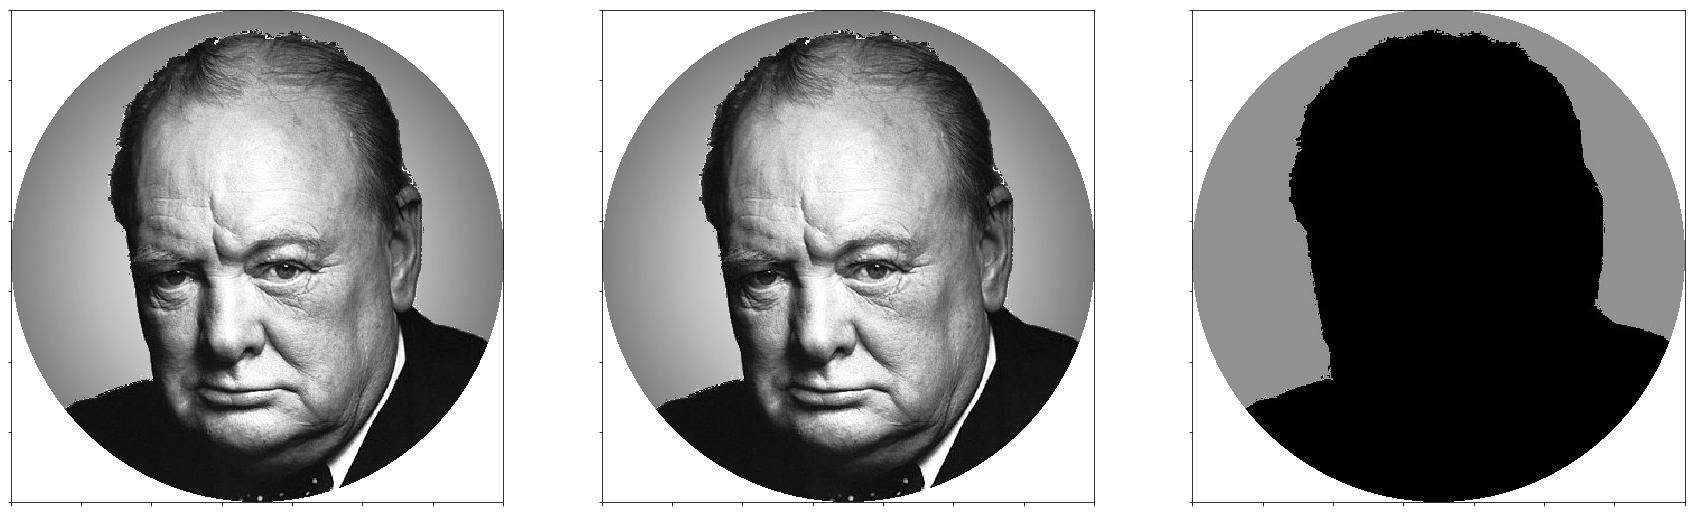

In [10]:
image_list = [image_m, image_m, image_w]
display_images(image_list)

In [15]:
lines = find_lines(image_m, n_lines=4000, 
                   darkness=170, lightness_penalty=0.55, 
                   w=image_w, line_norm_mode="weighted length",
                   time_saver=0.5)

4000/4000, average penalty = 62.91/101.09
time = 02:10


In [16]:
save_plot([lines], [(0,0,0)], "churchill output", 3500)
save_plot_progress([lines], [(0,0,0)], "churchill output", 3500, [0.2, 0.4, 0.6, 0.8, 1])

In [17]:
total_distance(lines)

distance = 1588 meters


In [ ]:
display_output(lines)